In [1]:
import torch
import torch.nn as nn
# import os
import numpy as np
# import math
import os
from torch.autograd import Variable
# from torch.utils.data import Dataset
# import torch.optim as optim 
# import random

# from sklearn.metrics import r2_score, explained_variance_score

# from networks.Network1_v1 import Network1, Network1_Data_loader
from networks.Network1_v5 import Network1, Network1_Data_loader
# from networks.Network2 import Network2, Network2_Data_loader
# from networks.Network3 import Network3, Network3_Data_loader

from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file

    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')

    start_time, end_time, time  = '', '', ''
    lin_ctr = 0

    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()

        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
#             if line_lst[0]=='LSM_raw: ' :
#                 print(line.rstrip(), file=out_file1, end=";\t\t")
            if line_lst[0]=='MPU_raw: ' :
                print(line.rstrip(), file=out_file1, end=";\t\t")
#             elif line_lst[0]=='LSM_ypr: ' :
#                 print(line.rstrip(), file=out_file1, end="\n")
            elif line_lst[0]=='MPU_ypr: ' :
                print(line.rstrip(), file=out_file1, end="\n")
#                 print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            

    end_time = time
    if end_time != '':
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")

    if (processed_filename2 is not None) and (end_time != ''):
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()

    out_file1.close()
    file.close()
    
def file_train_test_splitter(input_file_name, train_percent):
    # splits the input file into two files given by the train_percent
        # example usage : file_train_test_splitter("input.txt", 70)
    
    with open(input_file_name, 'r') as f:
        for i, l in enumerate(f):
            pass
    lines_in_file = i + 1   # total number of lines, aka, data points in the input file
    f.close()
    
    try:
        ratio = train_percent / 100
    except:
        print("Error: Invalid train test split ratio")
    
    num_train_data_points = int(lines_in_file * ratio)
    num_test_data_points = lines_in_file - num_train_data_points
    
    train_out_file = open(os.path.splitext(input_file_name)[0]+"_train_data.csv", 'w')
    test_out_file = open(os.path.splitext(input_file_name)[0]+"_test_data.csv", 'w')
    
    line_ctr = 0
    with open(input_file_name, 'r') as f:
        for line in f:
            line_ctr += 1
            line = line.rstrip()
            if line_ctr <= num_train_data_points:
                print(line, file = train_out_file)
            else:
                print(line, file = test_out_file)
    
    f.close()
    test_out_file.close()
    train_out_file.close()
    
    print("Train and test files created.")

In [3]:
# Data Pre-processing 
data_extractor("Datasets/MPU_rawtoypr_11.csv", "Datasets/MPU_rawtoypr_11_cleaned.csv")
file_train_test_splitter("Datasets/MPU_rawtoypr_11_cleaned.csv", 70)

Train and test files created.


### Deep Learning Network

In [28]:
model = Network1(init_weights=True)
print(model)

Network1(
  (fc1): Linear(in_features=9, out_features=9)
  (fc2): Linear(in_features=9, out_features=8)
  (fc3): Linear(in_features=8, out_features=8)
  (fc4): Linear(in_features=8, out_features=7)
  (fc5): Linear(in_features=7, out_features=7)
  (fc6): Linear(in_features=7, out_features=6)
  (fc7): Linear(in_features=6, out_features=6)
  (fc8): Linear(in_features=6, out_features=5)
  (fc9): Linear(in_features=5, out_features=5)
  (fc10): Linear(in_features=5, out_features=4)
  (fc11): Linear(in_features=4, out_features=4)
  (fc12): Linear(in_features=4, out_features=3)
  (relu): ReLU(inplace)
)


### Instantiating the Data Loader class

In [29]:
data_train = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_train_data.csv")    # training data LSM raw -> LSM ypr
data_test = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_test_data.csv") 

# yaw_dset_train_lpf98 = Data_loader("Datasets/360_yaw_lpf_98_data_cleaned.txt")     # training data LSM raw -> MPU ypr   
#yaw_dset_mpu_lpf98   = Data_loader("Datasets/mpu_360_yaw_lpf_98_data_cleaned.txt") # testing data MPU raw -> MPU ypr

In [30]:
print("Total training data samples = ", len(data_train))
print("Training Data matrix shape = ",data_train.data_matrix.shape)

print("Total test data samples = ", len(data_test))
print("Test Data matrix shape = ",data_test.data_matrix.shape)

Total training data samples =  6167
Training Data matrix shape =  (6167, 12)
Total test data samples =  2642
Test Data matrix shape =  (2642, 12)


#### Some pre training / testing initializations . . .

In [31]:
# Initializing the DataLoader(s)
dsets_enqueuer_training = torch.utils.data.DataLoader(data_train, batch_size=1, 
                                                      num_workers=1, drop_last=False)
dsets_enqueuer_testing = torch.utils.data.DataLoader(data_test, batch_size=1, 
                                                      num_workers=1, drop_last=False)

epochs = 100

### Training / Testing the network

In [32]:
loss_lst_train, loss_lst_test, r_sq_lst, r_sq_lst_test,  var_exp_lst, var_exp_lst_test = model.train_model(epochs, 
                                                                                         dsets_enqueuer_training, 
                                                                                         dsets_enqueuer_testing)




[ Training Network ]

Epoch 	1 / 100 , 	 loss = [[0.86119425 3.7157514  0.69846576]] , 	 R^2 = -21.9377 , 	 Var exp = -474.8187 %
Epoch 	2 / 100 , 	 loss = [[0.6538269 3.7157514 0.6730723]] , 	 R^2 = -20.8075 , 	 Var exp = -359.0469 %
Epoch 	3 / 100 , 	 loss = [[0.52247345 3.7157514  0.570732  ]] , 	 R^2 = -20.3006 , 	 Var exp = -308.8766 %
Epoch 	4 / 100 , 	 loss = [[0.5709125 3.7157514 0.606694 ]] , 	 R^2 = -20.5789 , 	 Var exp = -338.1949 %
Epoch 	5 / 100 , 	 loss = [[0.5269958  3.7157514  0.56575626]] , 	 R^2 = -20.0959 , 	 Var exp = -289.5371 %
Epoch 	6 / 100 , 	 loss = [[0.72614604 3.7157514  0.69699097]] , 	 R^2 = -21.1127 , 	 Var exp = -389.096 %
Epoch 	7 / 100 , 	 loss = [[0.7191134 3.7157514 0.6614099]] , 	 R^2 = -20.9358 , 	 Var exp = -373.6453 %
Epoch 	8 / 100 , 	 loss = [[0.84861356 3.7157514  0.792988  ]] , 	 R^2 = -21.8224 , 	 Var exp = -463.5147 %
Epoch 	9 / 100 , 	 loss = [[0.8599885 3.7157514 0.7871407]] , 	 R^2 = -21.5506 , 	 Var exp = -434.6286 %
Epoch 	10 / 100 

Epoch 	77 / 100 , 	 loss = [[0.41181603 3.7157514  0.40833294]] , 	 R^2 = -19.2801 , 	 Var exp = -209.2904 %
Epoch 	78 / 100 , 	 loss = [[0.42735595 3.7157514  0.42772776]] , 	 R^2 = -19.371 , 	 Var exp = -218.392 %
Epoch 	79 / 100 , 	 loss = [[0.41831127 3.7157514  0.41672003]] , 	 R^2 = -19.3098 , 	 Var exp = -212.2626 %
Epoch 	80 / 100 , 	 loss = [[0.43627548 3.7157514  0.4324655 ]] , 	 R^2 = -19.4511 , 	 Var exp = -226.2096 %
Epoch 	81 / 100 , 	 loss = [[0.43035033 3.7157514  0.42897975]] , 	 R^2 = -19.4664 , 	 Var exp = -227.8501 %
Epoch 	82 / 100 , 	 loss = [[0.41289452 3.7157514  0.4192357 ]] , 	 R^2 = -19.3016 , 	 Var exp = -211.4194 %
Epoch 	83 / 100 , 	 loss = [[0.43269613 3.7157514  0.4340032 ]] , 	 R^2 = -19.3768 , 	 Var exp = -218.9471 %
Epoch 	84 / 100 , 	 loss = [[0.40923962 3.7157514  0.40726525]] , 	 R^2 = -19.2552 , 	 Var exp = -206.7008 %
Epoch 	85 / 100 , 	 loss = [[0.391047   3.7157514  0.38996246]] , 	 R^2 = -19.1415 , 	 Var exp = -195.5106 %
Epoch 	86 / 100 , 	 l

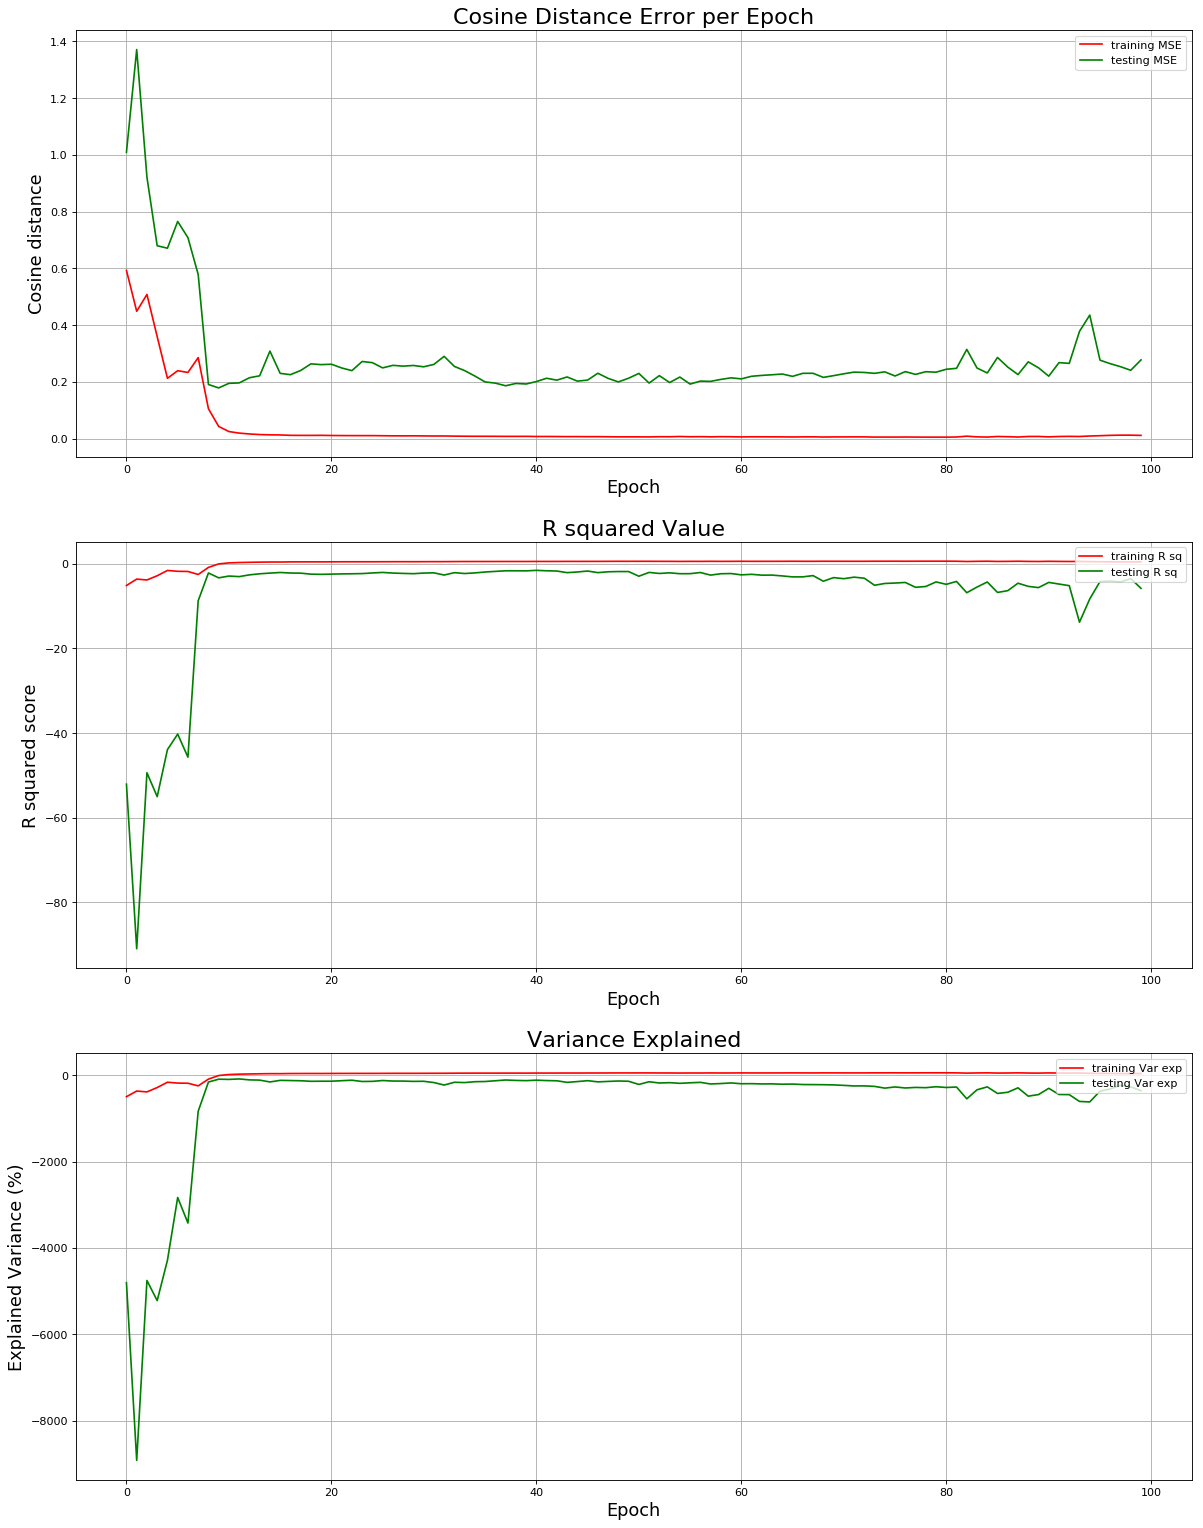

In [13]:
train_loss = np.squeeze(np.mean(np.array(loss_lst_train), axis=2))
test_loss = np.squeeze(np.mean(np.array(loss_lst_test), axis=2))

plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=80)

plt.subplot(311)
plt.title('Cosine Distance Error per Epoch', fontsize=20)
plt.plot( train_loss , 'r')            # this is the mean squared error among yaw, pitch, roll angles
plt.plot( test_loss  , 'g')            # can have a max value of 360^2 = 126000
# plt.plot( np.array(loss_lst_train) , 'r')            # this is the mean squared error among yaw, pitch, roll angles
# plt.plot( np.array(loss_lst_test)  , 'g')
plt.ylabel("Cosine distance", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training MSE', 'testing MSE'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title("R squared Value", fontsize=20)
plt.plot(r_sq_lst, 'r')
plt.plot(r_sq_lst_test, 'g')
plt.ylabel("R squared score", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training R sq', 'testing R sq'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title("Variance Explained", fontsize=20)
plt.plot(np.array(var_exp_lst) * 100, 'r')
plt.plot(np.array(var_exp_lst_test) * 100, 'g')
plt.ylabel("Explained Variance (%)", fontsize=16)
# plt.ylim(-100,110)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training Var exp', 'testing Var exp'], loc='upper right')
plt.grid()

plt.show()

### Loading Network weights that have the best testing loss

In [18]:
state_dict = model.load_from_checkpoint("/saved_model_weights/network_state_checkpoint80.pth")
model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/network_state_checkpoint80.pth 
...onto the CPU. 



In [25]:
data_test2 = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_test_data.csv", sequential_test_mode=True)
dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test2, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []
data_ctr = 0

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        y_lst.append(y)
        o_lst.append(output)
        data_ctr += 1
        if data_ctr >= 5000:
            break
        
# print("Model output \t= {} \ny \t\t= {}".format(np.squeeze(output.data.numpy()), 
#                                          np.squeeze(y.data.numpy())))
    

In [26]:
# model_output = np.squeeze(np.array(o_lst) )
model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

pitch_out, pitch_exp     = model_output[:,0], expected[:,0]
roll_out, roll_exp = model_output[:,1], expected[:,1]
yaw_out, yaw_exp   = model_output[:,2], expected[:,2]

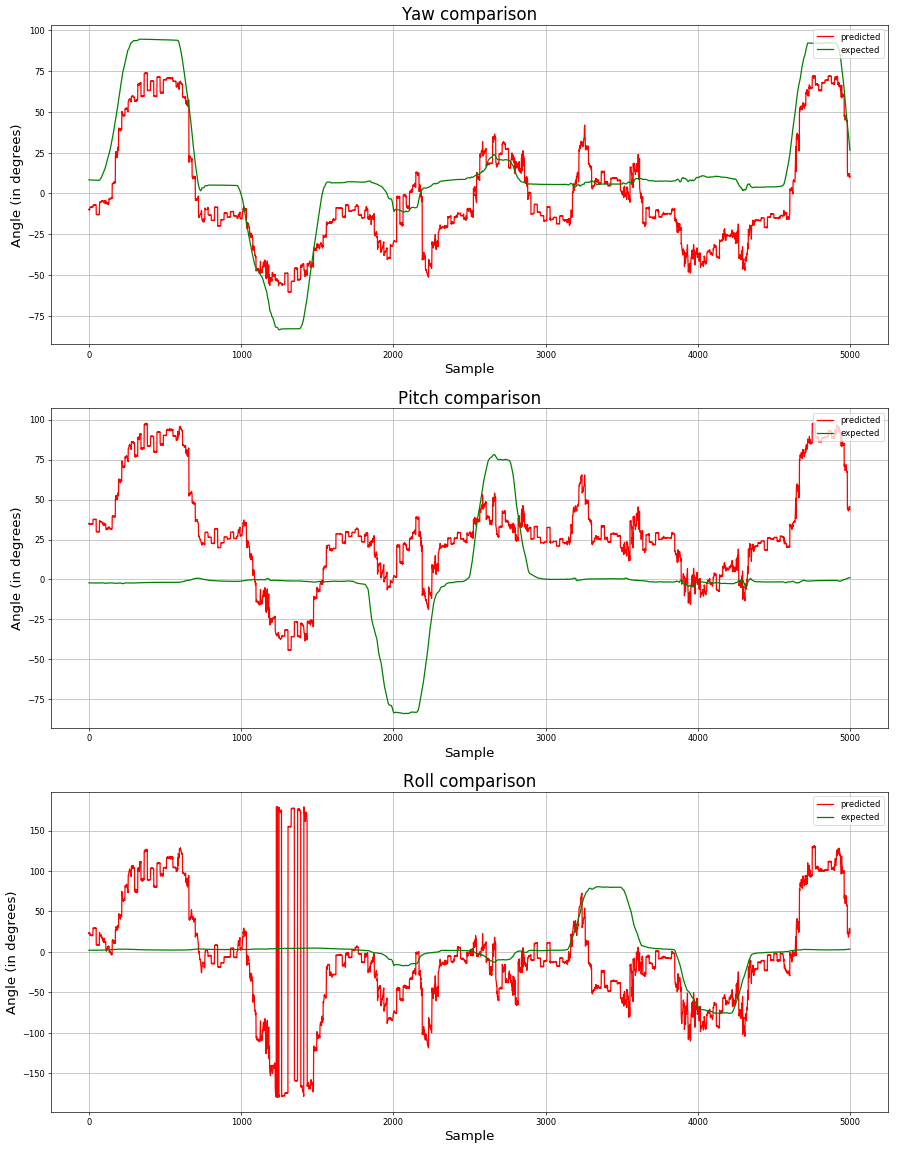

In [27]:
plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
plt.plot( yaw_out , 'r')            # model output
plt.plot( yaw_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
plt.plot( pitch_out , 'r')            # model output
plt.plot( pitch_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
plt.plot( roll_out , 'r')            # model output
plt.plot( roll_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.show()